# 欢迎
#FIXME: 欢迎的开场


## 背景 & 目标读者
#FIXME

本文主要打算利用简易医疗数据集, 构建一个简易的逻辑回归模型, 并把**模型训练过程中权重变化和模型分类结果**用可视化的手段展示出来

目标读者: 我们假设你是有线性代数基础的, 有一定医学背景的, 并且有编程基础的, 想了解和学习机器学习在医疗领域的应用的朋友们.

如果读者想了解线性代数基础, 或者编程相关的课程, 可以参考下面推荐的一下资料

## 推荐相关资料
### 线性代数
pass

### Python, Numpy, Pandas 教程
pass

### Anaconda & PyTorch 的安装和使用
pass

## 关于本文的结构
1. 熟悉数据集 Understand Dataset
2. 构建逻辑回归模型 Build Logistic Regression Model
3. 可视化和结果分析 Visialization & Result Analysis


---
TODO list:
- [ ] 构建模型, 暂时把权重的变化以打印的方式输出
- [ ] 丰富文案: 补充开场白, 对数据集的描述, 对每个步骤的描述, 结论分析 etc. **需要其他老板支持**
- [ ] 优化notebook: 可视化工具

其他待优化问题:
1. 目前的随机种子方法没办法保证结果的一致性, 很难通过超参控制模型训练后的结果, 导致很难保证权重有比较大的变化性, 不好可视化
2. 用打印的方法展示权重不够直观

# 1. 熟悉数据集 Understand Dataset
FIXME 补充关于数据集的描述, 这是什么数据集, 数据集的统计等

细胞分类: 在医学角度来说, 细胞核面积与细胞质面积的占比是专家用于判断细胞是否是癌细胞的一个重要指标. 

在数据集中列 Class 代表细胞的不同的核质比, 范围从 1 到 7. 以下是不同颗粒度对细胞的分类方法, 本文构建的是简易二分类逻辑回归模型, 所以用第一种的分类方法
1. 粗分类, {1, 2, 3} 是正常细胞, {4, 5, 6, 7} 是非正常细胞
2. 中分类: {1, 2} 占比较小, {3, 4, 5, 6} 占比中等, {7} 占比较大;
3. 细分类: 直接 1 到 7 分类

In [73]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random, os

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 设置随机种子
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
seed_torch()

In [4]:
# 1. 读取数据集
# 用户要自己修改文件路径
path_data = '/Users/panxingnan/QuickTourForDeepLearning/Example/Logistic Regression/data/new_database_results.xls'
data = pd.read_excel(path_data, sheet_name='results')
data.head(5)

,ID,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,...,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class,ClassName1,ClassName2
0,153958345-153958392-001.BMP,803.500,27804.125,0.028087,85.866083,192.524631,29.832191,34.828150,0.856554,0.843403,...,101.375,673.500,0.230067,44,37,649,655,1,normal_superficiel,normal
1,153960256-153960295-002.BMP,610.125,18067.875,0.032665,81.531353,153.439838,25.319871,30.805844,0.821918,0.818583,...,85.250,597.000,0.043701,36,26,502,504,1,normal_superficiel,normal
2,157181281-157181308-001.BMP,990.375,79029.875,0.012377,77.843655,118.001177,33.552901,38.327536,0.875425,0.858397,...,111.750,1059.125,0.141150,53,37,2267,2500,1,normal_superficiel,normal
3,157181387-157181418-001.BMP,554.500,98941.000,0.005573,70.054545,139.359845,23.799254,29.832868,0.797753,0.793271,...,81.000,1264.500,0.079801,38,29,2885,2960,1,normal_superficiel,normal
4,157181525-157181540-001.BMP,636.375,99663.250,0.006345,76.950949,137.748293,25.946189,31.256999,0.830092,0.829332,...,87.875,1250.625,0.121304,36,24,2978,3159,1,normal_superficiel,normal


数据预处理
1. 去掉不必要的列
2. 根据 class 数值, 生成 label, label 就是我们要预测的值
3. 将特征列归一化
4. 将数据集分成训练集和测试集, 随机抽样

In [5]:
# 1. 去掉不必要的列
df = data.drop(['ID', 'ClassName1', 'ClassName2'], axis=1)

# 2. 分箱
bins = [0, 3, 7]
df['label'] = pd.cut(df['Class'], bins=bins, labels=[0, 1])
print('分组后的结果')
df[['Class', 'label']].drop_duplicates()

分组后的结果


,Class,label
0,1,0
74,2,0
144,3,0
242,4,1
424,5,1
570,6,1
767,7,1


In [6]:
print('正负样本数量')
df[['label']].value_counts()

正负样本数量


label
1        675
0        242
dtype: int64

In [7]:
# 3. 归一化, 采用 0 均值标准化
label = df['label']
feature = df.drop('label', axis=1)

print('归一化前数值')
feature.head(2)

归一化前数值


,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,...,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class
0,803.500,27804.125,0.028087,85.866083,192.524631,29.832191,34.828150,0.856554,0.843403,181.574886,...,0.750175,0.604273,101.375,673.5,0.230067,44,37,649,655,1
1,610.125,18067.875,0.032665,81.531353,153.439838,25.319871,30.805844,0.821918,0.818583,171.108766,...,0.866065,0.589351,85.250,597.0,0.043701,36,26,502,504,1


In [8]:
feature = (feature - feature.mean())/feature.std()
print('归一化后数值')
feature.head(2)

归一化后数值


,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,...,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class
0,-1.164601,0.675432,-1.539731,-0.212305,2.125615,-1.208496,-1.564634,0.678200,0.891219,0.882348,...,0.328428,1.291274,-1.471815,0.667500,-0.268492,-1.111085,-0.905485,0.366248,0.372045,-1.969975
1,-1.267560,0.197172,-1.518272,-0.411325,0.563027,-1.449092,-1.737695,0.456926,0.730725,0.736792,...,0.981822,1.204862,-1.709653,0.389174,-1.397596,-1.250199,-1.106092,0.134320,0.129158,-1.969975


In [9]:
feature['label'] = label
df_preprocess = feature
df_preprocess.head(3)

,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,...,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class,label
0,-1.164601,0.675432,-1.539731,-0.212305,2.125615,-1.208496,-1.564634,0.678200,0.891219,0.882348,...,1.291274,-1.471815,0.667500,-0.268492,-1.111085,-0.905485,0.366248,0.372045,-1.969975,0
1,-1.267560,0.197172,-1.518272,-0.411325,0.563027,-1.449092,-1.737695,0.456926,0.730725,0.736792,...,1.204862,-1.709653,0.389174,-1.397596,-1.250199,-1.106092,0.134320,0.129158,-1.969975,0
2,-1.065103,3.191719,-1.613363,-0.580639,-0.853791,-1.010109,-1.414071,0.798760,0.988172,2.393732,...,2.394885,-1.318787,2.070500,-0.807197,-0.954583,-0.905485,2.919033,3.339759,-1.969975,0


In [10]:
# 4. 划分训练集和测试集, 随机抽样, 可能会造成训练集和测试集的正负样本分布不一致
df_train = df_preprocess.sample(frac=0.8, axis=0)
df_test = df_preprocess[~df_preprocess.index.isin(df_train.index)]

print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

1    544
0    190
Name: label, dtype: int64
1    131
0     52
Name: label, dtype: int64


# 2. 构建逻辑回归模型 Build Logistic Regression Model
1. 构建数据集
2. 构建模型
3. 设置超参和损失函数
4. 训练和预测结果

In [11]:
# 构建数据集
class MyDataset(Dataset):
    def __init__(self, df:pd.DataFrame):
        feature = df.iloc[:, 0:-1].values
        label = df.iloc[:, -1].values

        self.feature = torch.tensor(feature, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
        return self.feature[index], self.label[index]

class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [95]:
# 初始化数据集和模型
ds_train = MyDataset(df_train)
ds_test = MyDataset(df_test)
print('特征输入的维度是: {}维, 并初始化模型'.format(df_train.shape[-1]-1))
LR = LogisticRegression(df_train.shape[-1]-1)

# 设置超参
epoches = 15
learning_rate=0.01
batch_size = 32
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.SGD(LR.parameters(), lr=learning_rate)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

# 开始训练
losses_train = []
losses_test = []
weights = None
predictions = []
print('开始训练')
for epoch in range(epoches):
    # 训练阶段
    LR.train(True)
    losses_cur_epoch = []
    for index, data in enumerate(dl_train):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = LR(inputs)
        outputs = outputs.squeeze(-1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        losses_cur_epoch.append(loss.item())
    loss_cur_train = np.mean(losses_cur_epoch)
    losses_train.append(loss_cur_train)

    total = 0
    correct = 0
    LR.train(False)
    losses_cur_epoch = []
    prediction_cur = None
    for index, data in enumerate(dl_test):
        inputs, labels = data
        outputs = LR(inputs)
        outputs = outputs.squeeze(-1)
        loss = loss_function(outputs, labels)
        losses_cur_epoch.append(loss.item())
        total += labels.size(0)
        correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == labels.detach().numpy())

        # 获得输出结果
        if prediction_cur is None: prediction_cur = outputs.detach().numpy()
        else: prediction_cur = np.hstack((prediction_cur, outputs.detach().numpy()))

    loss_cur_test = np.mean(losses_cur_epoch)
    losses_test.append(loss_cur_test)
    predictions.append(prediction_cur)

    # 提取模型权重
    w1 = LR.linear.weight.detach().numpy().squeeze()
    b1 = LR.linear.bias.detach().numpy()
    merge = np.concatenate((w1, b1))
    if weights is None: weights = merge
    else: weights = np.vstack((weights, merge))

    print('epoch {:2d} accuracy: {:.4f}, loss_train: {:.4f}, loss_test: {:.4f}'.format(epoch, correct/total, loss_cur_train,loss_cur_test))
print('训练完成')

特征输入的维度是: 21维, 并初始化模型
开始训练
epoch  0 accuracy: 0.7923, loss_train: 0.5229, loss_test: 0.5134
epoch  1 accuracy: 0.8306, loss_train: 0.4362, loss_test: 0.4517
epoch  2 accuracy: 0.8525, loss_train: 0.3874, loss_test: 0.4124
epoch  3 accuracy: 0.8470, loss_train: 0.3543, loss_test: 0.3843
epoch  4 accuracy: 0.8470, loss_train: 0.3301, loss_test: 0.3628
epoch  5 accuracy: 0.8634, loss_train: 0.3112, loss_test: 0.3455
epoch  6 accuracy: 0.8689, loss_train: 0.2955, loss_test: 0.3313
epoch  7 accuracy: 0.8852, loss_train: 0.2824, loss_test: 0.3191
epoch  8 accuracy: 0.8907, loss_train: 0.2712, loss_test: 0.3085
epoch  9 accuracy: 0.8962, loss_train: 0.2614, loss_test: 0.2992
epoch 10 accuracy: 0.9016, loss_train: 0.2527, loss_test: 0.2909
epoch 11 accuracy: 0.9016, loss_train: 0.2449, loss_test: 0.2834
epoch 12 accuracy: 0.9016, loss_train: 0.2378, loss_test: 0.2766
epoch 13 accuracy: 0.9016, loss_train: 0.2313, loss_test: 0.2704
epoch 14 accuracy: 0.9071, loss_train: 0.2254, loss_test: 0.264

# 3. 可视化和结果分析 Visialization & Result Analysis
对于模型来说, 有很多衡量的方法, 其中 AUC, 真阳率, 真阴率在医学上比较重要. (不知道是不是这么叫啊)

In [107]:
# 可视化权重变化
# FIXME
print('权重变化')
pd.set_option('display.max_colwidth', None)
cols = list(df_train.columns.values)[:-1]
cols.append('bias')
df_weights = pd.DataFrame(weights, columns=cols)
df_weights

权重变化


,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,...,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class,bias
0,0.095013,-0.178193,0.169148,0.052806,-0.157028,0.042725,0.182443,0.091796,0.026265,0.157634,...,0.149989,-0.019424,-0.206517,0.164265,0.143718,0.029249,-0.008385,0.012936,0.046922,0.245823
1,0.123075,-0.202843,0.194126,0.072312,-0.146694,0.071770,0.219342,0.080188,0.012179,0.137375,...,0.128761,0.015562,-0.225423,0.157455,0.167317,0.049806,-0.033014,-0.010658,0.096717,0.286275
2,0.145281,-0.220837,0.211487,0.086246,-0.139200,0.095182,0.248685,0.071450,0.001687,0.123318,...,0.114701,0.043325,-0.238687,0.149589,0.185593,0.065512,-0.051207,-0.027974,0.138672,0.323942
3,0.163851,-0.235112,0.224444,0.096600,-0.133594,0.115114,0.273291,0.064513,-0.006600,0.112742,...,0.104698,0.066553,-0.248799,0.141488,0.200461,0.078113,-0.065804,-0.041803,0.175756,0.358966
4,0.179597,-0.247055,0.234369,0.104520,-0.129356,0.132367,0.294349,0.058822,-0.013374,0.104315,...,0.097634,0.086404,-0.257084,0.133411,0.212795,0.088405,-0.078145,-0.053460,0.209415,0.391890
5,0.193444,-0.257385,0.242238,0.110740,-0.125994,0.147822,0.312950,0.054090,-0.019005,0.097320,...,0.092326,0.103924,-0.264090,0.125589,0.223404,0.097138,-0.088911,-0.063610,0.240637,0.422828
6,0.205791,-0.266300,0.248315,0.115436,-0.123555,0.161833,0.329572,0.050157,-0.023690,0.091615,...,0.088628,0.119548,-0.269916,0.117984,0.232647,0.104663,-0.098308,-0.072440,0.269712,0.452012
7,0.216927,-0.274380,0.253213,0.119245,-0.121599,0.174642,0.344667,0.046667,-0.027798,0.086606,...,0.085953,0.133694,-0.275127,0.110627,0.240813,0.111191,-0.106897,-0.080500,0.297210,0.479812
8,0.227112,-0.281651,0.257084,0.122212,-0.120091,0.186519,0.358502,0.043654,-0.031332,0.082294,...,0.084094,0.146642,-0.279682,0.103558,0.248141,0.116967,-0.114701,-0.087810,0.323314,0.506270
9,0.236350,-0.288303,0.260123,0.124332,-0.119161,0.197493,0.371107,0.041126,-0.034313,0.078499,...,0.083031,0.158429,-0.283800,0.096738,0.254641,0.122009,-0.121898,-0.094544,0.348213,0.531606


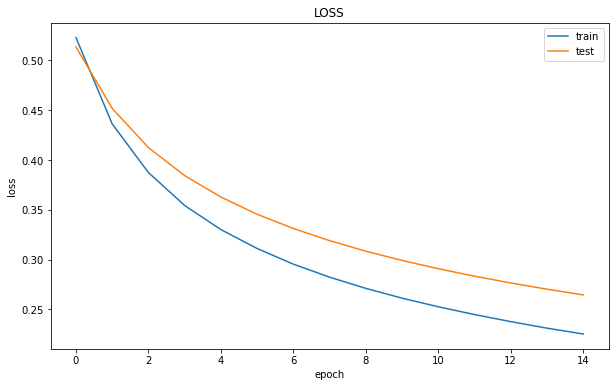

In [96]:
# loss
plt.figure(figsize=(10, 6))
x = np.arange(0, epoches)
plt.plot(x, losses_train, label='train')
plt.plot(x, losses_test, label='test')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [97]:
# 计算 auc, 真阳率(true positive rate), 真阴率(true negative rate)
from sklearn.metrics import confusion_matrix, roc_auc_score
label_true = df_test['label'].to_numpy()
aucs, tprs, tnrs = [], [], []
theshold = 0.5

for pred in predictions:
    aucs.append(roc_auc_score(label_true, pred))
    tmp = pred.copy()
    tmp[tmp >= theshold] = 1
    tmp[tmp < theshold] = 0
    tn, fp, fn, tp = confusion_matrix(label_true, tmp).ravel()
    tprs.append(tp/(tp+fn))
    tnrs.append(tn/(tn+fp))

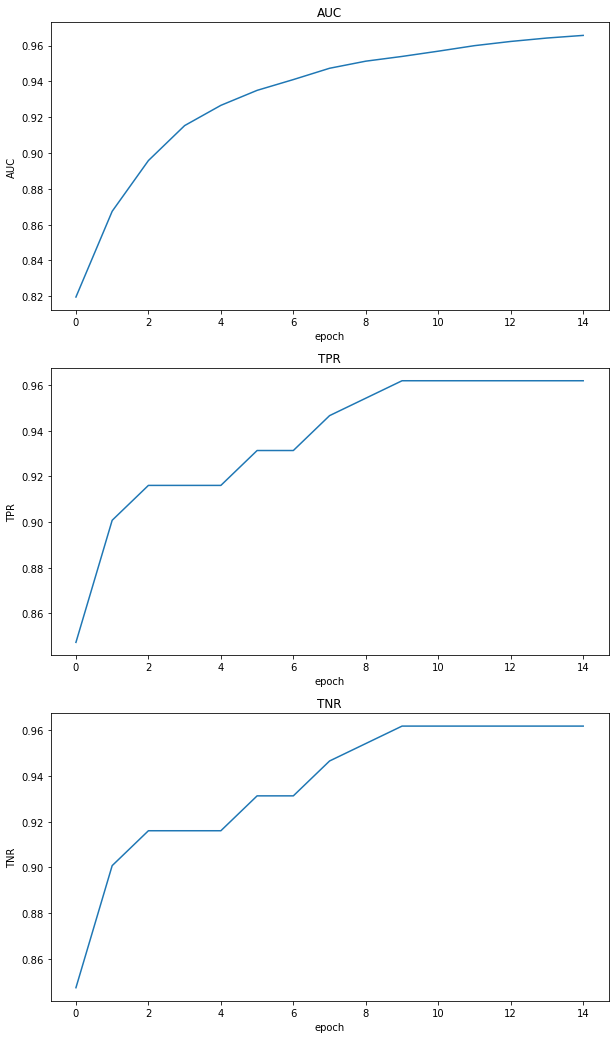

In [98]:
plt.figure(figsize=(10, 18))
tittle = 'AUC TPR TNR'.split()
x = np.arange(0, epoches)
for index, matric in enumerate([aucs, tprs, tprs]):
    plt.subplot(3, 1, index+1)
    plt.plot(x, matric)
    plt.title(tittle[index])
    plt.xlabel('epoch')
    plt.ylabel(tittle[index])
plt.show()